In [ ]:
import json
import os 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rag_fine_tuning import create_vector_store, convert_context_to_langchain_docs
from rag_fine_tuning import query_vector_store, save_llm_answers, fine_tune_rag
from data_utils import convert_json_to_dataframe, create_json_subset, collect_all_results
sns.set_style("whitegrid")
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Useful material 
# SQuAD Evaluation guidelines: 
# https://worksheets.codalab.org/worksheets/0x8212d84ca41c4150b555a075b19ccc05/
# https://rajpurkar.github.io/SQuAD-explorer/

# Convert json data to pandas dataframe 

In [2]:
convert_json_to_dataframe()

Saving dataframe of shape:  (11873, 14)


In [6]:
df_all_data = pd.read_csv("dataset.csv")
df_all_data.shape

(11873, 14)

In [9]:
df_selected = df_all_data.copy()

In [10]:
# some rough statistics for the context length 
df_selected.loc[:, "context_chars"] = df_selected["context"].apply(lambda x: len(x))
df_selected.loc[:, "context_words"] = df_selected.loc[:, "context"].apply(lambda x: len(x.split(" ")))

In [12]:
df_selected.head(2)

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5,context_chars,context_words
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113


<Axes: xlabel='context_chars', ylabel='Count'>

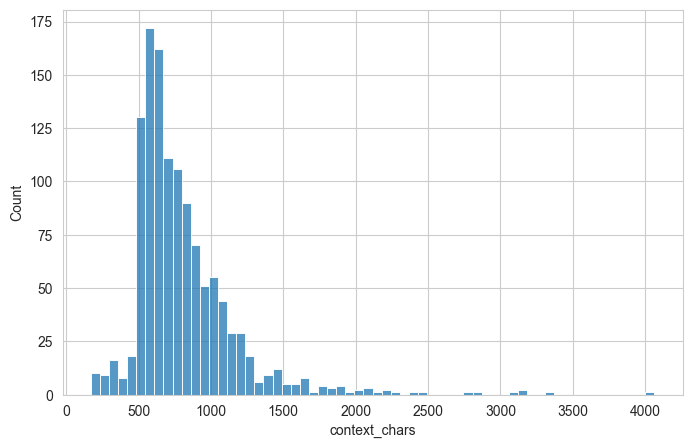

In [13]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_chars"])

<Axes: xlabel='context_words', ylabel='Count'>

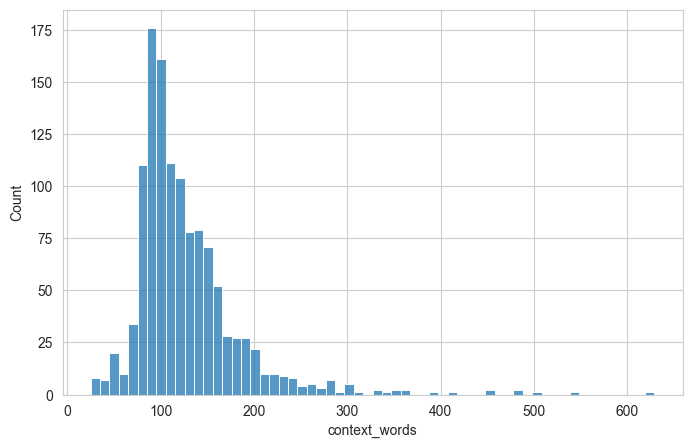

In [14]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_words"])

In [ ]:
# create original json structure for only a subset of questions, used for tests and fine-tuning 
# this file will be used by the evaluation.py file 

df = pd.read_csv("dataset.csv")
df_sel = df[0:500]
df_sel.head(2)

create_json_subset(df_sel)

# RAG architecture

Steps:

**Data Indexing**

Converting text data into a searchable database of vector embeddings, which represent the meaning of the text in a format that computers can easily understand.
- **Documents Chunking**: The collection of documents is split into smaller chunks of text. This allows for more precise and relevant pieces of information to be fed into the language model when needed, avoiding information overload.
- **Vector Embeddings**: The chunks of text are then transformed into vector embeddings. These embeddings encode the meaning of natural language text into numerical representations.
- **Vector Database**: Finally, the vector embeddings are stored in a vector database, making them easily searchable.

**Documents -> Text chunks -> Vector Embeddings -> Vector DB**

**Load -> Split -> Embed -> Store**

## Convert the pandas context to Langchain documents 

In [2]:
df = pd.read_csv("dataset.csv")

langchain_docs = convert_context_to_langchain_docs(df)

In [3]:
print(len(langchain_docs))
print(langchain_docs[0])
print(langchain_docs[1])

1204
page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.' metadata={'title': 'Normans'}
page_content='The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christ

## Vector database

In [3]:
embeddings_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embeddings_model)

db_dir = os.path.join(os.getcwd(), "vector_databases")


In [12]:
create_vector_store(langchain_docs, embeddings, store_name="test_vector_store", db_dir=db_dir, chunk_size=200, chunk_overlap=15)

Vector store test_vector_store already exists. No need to initialize.


## Querying the vector database 

In [ ]:
query = "How is the weather today in Milan?"
store_name =  "test_vector_store"
relevant_docs = query_vector_store(store_name, query, embeddings, db_dir, k=3, score_threshold=0.1)

print(relevant_docs)

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:90: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
No relevant docs were retrieved using the relevance score threshold 0.1


[]


In [6]:
query = "Who were the normans?"
store_name =  "test_vector_store"
relevant_docs = query_vector_store(store_name, query, embeddings, db_dir, k=3, score_threshold=0.1)

print(len(relevant_docs))

for doc in relevant_docs:
    print(doc.page_content)

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:91: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


3
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France
. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they assimilated


## Run the RAG over a subset of questions and save the answers 

In [5]:
df_to_test = pd.read_csv("dataset.csv")
df_to_test = df_to_test[0:500]

In [ ]:
embeddings_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embeddings_model)

save_llm_answers(df_to_test, langchain_docs, embeddings, embeddings_model, chunk_size=150, filename="test_predictions.json")

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_150_text-embedding-3-small
Vector store chroma_db_openai already exists. No need to initialize.


  0%|          | 0/500 [00:00<?, ?it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:91: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
 81%|████████  | 403/500 [08:27<03:06,  1.92s/it]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 451, 'title': 'Force'}, page_content='from ordered to more random conditions as entropy increases'), -0.10112879189601554), (Document(metadata={'start_index': 103, 'title': 'Force'}, page_content='. This is often due to macrophysical co

## RAG Fine-tuning 

Comments
Peak distribution for number of characters in the documents is ~600 words. 
- smaller chunks: reduced noise from irrelevant content - works well with dense embeddings*
- larger chunks: preserves context better; ideal if queries require full document context, works well with hybrid search*

TEXT CHUNKING 

1. CHARACTER SPLITTING : divide the text into N-character sized chunks. Can split words in the middle. 
2. RECURSIVE CHARACTER SPLITTING: preserves sentences. Avoids splitting sentences midword (note that RecursiveCharacterTextSplitter with separator does exactly that). Split the
document where a double new line is present, then, if the chunk size is still exceeded, split at new lines, and so on.
3. SEMANTIC SPLITTING: keeps related content together. Use embeddings to split based on meaning.
+ other techniques

EMBEDDINGS 
Create fixed-length vector representation of text, focusing on semanting meaning for tasks like similarity comparison. 
Most up to date embedding models, both proprietary and open source, with performance metrics across different tasks: https://huggingface.co/spaces/mteb/leaderboard 
This contains also a "retrieval" column with performance metrics. Click on the column to sort the models.
Interesting article: https://www.mongodb.com/developer/products/atlas/choose-embedding-model-rag/


In [ ]:
df = pd.read_csv("dataset.csv")
df_to_test = df[0:500]

langchain_docs = convert_context_to_langchain_docs(df)

fine_tune_rag(df_to_test, langchain_docs)

Running gpt-3.5-turbo - 100 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 200 - text-embedding-3-small
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_200_text-embedding-3-small
Vector store chroma_db_openai already exists. No need to initialize.


  0%|          | 0/500 [00:00<?, ?it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:95: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
No relevant docs were retrieved using the relevance score threshold 0.1
100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


Running gpt-3.5-turbo - 400 - text-embedding-3-small
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_400_text-embedding-3-small

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


 16%|█▋        | 82/500 [01:20<05:49,  1.20it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 428, 'title': 'Normans'}, page_content=". Having spent time at the court of Henry I of England (married to David's sister Maud of Scotland), and needing them to wrestle the kingdom from his half-brother Máel Coluim mac Alaxandair, David had to reward many with lands. The process was continued under David's successors, most intensely of all under William the Lion"), -0.032232881102496336), (Document(metadata={'start_index': 691, 'title': 'Huguenot'}, page_content='. They were very successful at marriage and property speculation. After petitioning the British Crown in 1697 for the right to own land in the Baronies, they prospered as slave owners on the Cooper, Ashepoo, Ashley and Santee River plantations they

Running gpt-3.5-turbo - 500 - text-embedding-3-small
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_500_text-embedding-3-small

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


 16%|█▋        | 82/500 [01:55<06:40,  1.04it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 495, 'title': 'Normans'}, page_content=". His stay in Normandy (until 1016) influenced him and his sons by Emma, who stayed in Normandy after Cnut the Great's conquest of the isle."), 0.03684403343922149), (Document(metadata={'start_index': 276, 'title': 'Huguenot'}, page_content='. After the Revocation of the Edict of Nantes in 1685, several Huguenot families of Norman and Carolingian nobility and descent, including Edmund Bohun of Suffolk England from the Humphrey de Bohun line of French royalty descended from Charlemagne, Jean Postell of Dieppe France, Alexander Pepin, Antoine Poitevin of Orsement France, and Jacques de Bordeaux of Grenoble, immigrated to the Charleston Orange district. They were very su

Running gpt-3.5-turbo - 600 - text-embedding-3-small
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_600_text-embedding-3-small

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


 16%|█▋        | 82/500 [01:18<05:24,  1.29it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 495, 'title': 'Normans'}, page_content=". His stay in Normandy (until 1016) influenced him and his sons by Emma, who stayed in Normandy after Cnut the Great's conquest of the isle."), 0.03684403343922149), (Document(metadata={'start_index': 276, 'title': 'Huguenot'}, page_content='. After the Revocation of the Edict of Nantes in 1685, several Huguenot families of Norman and Carolingian nobility and descent, including Edmund Bohun of Suffolk England from the Humphrey de Bohun line of French royalty descended from Charlemagne, Jean Postell of Dieppe France, Alexander Pepin, Antoine Poitevin of Orsement France, and Jacques de Bordeaux of Grenoble, immigrated to the Charleston Orange district. They were very su

In [ ]:
df_all_res = collect_all_results()
df_all_res.to_csv("eval_results/df_all_results.csv", index=False)